In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from data_tools import combine_nodes_and_edges
from data_tools.wiki import get_curi_xrefs
from data_tools.plotting import venn2_pretty, count_plot_h
from data_tools.df_processing import expand_col_on_char, expand_df_on_col, expand_split_col, combine_group_cols_on_char

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('../0_data/external/gaussWithIdentifierMatch.tsv', sep='\t')

In [3]:
df.head(2)

,DB,ICD9code,PID,cases,category,controls,gaussName,geneSet,pval,selectedGenes
0,DOID:11329,136.0,GO:0005549,205.0,infectious diseases,408429.0,Other infectious and parasitic diseases,GO_ODORANT_BINDING,0.004,"OR5H6,OR5K3,OR5K4,OR5L2,OR5J2,OR8U1,OR8A1,OR11..."
1,DOID:3277,164.0,GO:0005549,57.0,neoplasms,406226.0,Cancer of intrathoracic organs,GO_ODORANT_BINDING,0.020,"OR5B2,OR8J3,OR5H1,OR5H14,OR5D13,OR8H3,OR5B12,O..."


In [4]:
df['dis_source'] = df['DB'].apply(lambda s: s.split(':')[0])

In [5]:
df['gset_source'] = df['PID'].apply(lambda s: s.split(':')[0])

In [6]:
nodes = pd.read_csv('../2_pipeline/08_CTD/out/nodes_filt.csv', dtype=str)
edges = pd.read_csv('../2_pipeline/08_CTD/out/edges.csv', dtype=str)

In [7]:
combo = combine_nodes_and_edges(nodes, edges)

# Map Disease and get Gene to disease links

### Mapping To the Network

In [8]:
umls_to_nw = get_curi_xrefs(nodes, 'UMLS')
mesh_to_nw = get_curi_xrefs(nodes, 'MESH')
doid_to_nw = get_curi_xrefs(nodes, 'DOID')

In [9]:
umls_to_nw.head(2)

,id,xrefs
23170,DOID:0001816,UMLS:C0018923
23171,DOID:0001816,UMLS:C0854893


In [10]:
nw_ids = nodes['id'].tolist()

In [11]:
umls_mrg = df.merge(umls_to_nw.rename(columns={'xrefs': 'DB'}), on='DB', how='inner')
mesh_mrg = df.merge(mesh_to_nw.rename(columns={'xrefs': 'DB'}), on='DB', how='inner')
doid_mrg = df.merge(doid_to_nw.rename(columns={'xrefs': 'DB'}), on='DB', how='inner')
direct_map = df.query('DB in @nw_ids').copy()
direct_map['id'] = direct_map['DB']

dis_mapped = pd.concat([umls_mrg, mesh_mrg, doid_mrg, direct_map]).drop_duplicates()
dis_mapped = dis_mapped.rename(columns={'id': 'dis_id'})

In [12]:
len(dis_mapped)

37135

### Getting Disease to Gene Links

In [13]:
sym_xref = get_curi_xrefs(nodes, 'SYM')

In [14]:
dis_exp = expand_col_on_char(dis_mapped, 'selectedGenes', ',')
dis_exp['selectedGenes'] = 'SYM:' + dis_exp['selectedGenes']
dis_exp = dis_exp.merge(sym_xref.rename(columns={'id': 'gene_id', 'xrefs': 'selectedGenes'}), how='left')

In [15]:
dis_exp['gene_id'].count() / len(dis_exp)

0.9628322424791695

In [16]:
dis_gene = dis_exp.dropna(subset=['dis_id', 'gene_id'])[['dis_id', 'gene_id']].drop_duplicates()

len(dis_gene)

128026

In [17]:
gene_dis_tups = dis_gene[['gene_id', 'dis_id']].dropna().apply(tuple, axis=1)

### Compare these mappings to those in NW

In [18]:
gene_ids = dis_gene['gene_id'].dropna().unique()
g_lbl = nodes.query('id in @gene_ids')['label'].unique()

dis_ids = dis_gene['dis_id'].unique()
dis_lbl = nodes.query('id in @dis_ids')['label'].unique()

In [19]:
nw_gd_e_tup = combo.query('start_label in @g_lbl and end_label in @dis_lbl')[['start_id', 'end_id']].apply(tuple, axis=1)

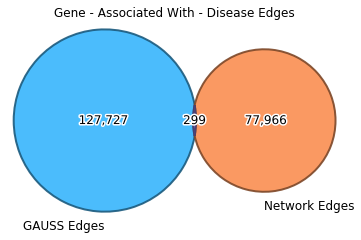

In [20]:
v = venn2_pretty([set(gene_dis_tups), set(nw_gd_e_tup)], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Associated With - Disease Edges');

# Map Genesets to network and get Gene to GeneSet Edges

### Map the genesets to the network

In [21]:
df['gset_source'].value_counts()

GO              55087
KEGG             2031
R-HSA-379726       94
R-HSA-381753       85
R-HSA-140342       79
                ...  
R-HSA-418346        5
R-HSA-112316        3
R-HSA-74751         3
R-HSA-421270        2
R-HSA-392499        2
Name: gset_source, Length: 206, dtype: int64

In [22]:
react_idx = df.query('gset_source not in {}'.format(['GO', 'KEGG'])).index

df.loc[react_idx, 'gset_source'] = 'REACT'
df.loc[react_idx, 'PID'] = 'REACT:' + df.loc[react_idx, 'PID']

df['gset_source'].value_counts()

GO       55087
REACT     5815
KEGG      2031
Name: gset_source, dtype: int64

In [23]:
go_to_nw = get_curi_xrefs(nodes, 'GO')
kegg_to_nw = get_curi_xrefs(nodes, 'KEGG')
react_to_nw = get_curi_xrefs(nodes, 'REACT')

In [24]:
nw_kegg_ids = nodes[nodes['id'].str.startswith('KEGG:')]['id'].unique()

In [25]:
nw_kegg_ids[:10]

array(['KEGG:hsa00010', 'KEGG:hsa00020', 'KEGG:hsa00030', 'KEGG:hsa00040',
       'KEGG:hsa00051', 'KEGG:hsa00052', 'KEGG:hsa00053', 'KEGG:hsa00061',
       'KEGG:hsa00062', 'KEGG:hsa00071'], dtype=object)

In [26]:
df.query('gset_source == "KEGG"')['PID'].values[:10]

array(['KEGG:04740', 'KEGG:00310', 'KEGG:04512', 'KEGG:04740',
       'KEGG:04610', 'KEGG:00310', 'KEGG:05200', 'KEGG:05222',
       'KEGG:04740', 'KEGG:04742'], dtype=object)

There appears to be a species tag that is missing from this data source.  We will add it with a custom function

In [27]:
def add_kegg_hsa(kegg_id):
    pref, kid = kegg_id.split(':')
    
    try:
        # If it is an integer, needs hsa, otherwise keep as is
        int_kid = int(kid)
    except:
        return kegg_id
    
    return 'KEGG:hsa{}'.format(kid)

In [28]:
kegg_idx = df.query('gset_source == "KEGG"').index

df.loc[kegg_idx, 'PID'] = df.loc[kegg_idx, 'PID'].apply(add_kegg_hsa)
df.query('gset_source == "KEGG"')['PID'].values[:10]

array(['KEGG:hsa04740', 'KEGG:hsa00310', 'KEGG:hsa04512', 'KEGG:hsa04740',
       'KEGG:hsa04610', 'KEGG:hsa00310', 'KEGG:hsa05200', 'KEGG:hsa05222',
       'KEGG:hsa04740', 'KEGG:hsa04742'], dtype=object)

In [29]:
len(set(nw_kegg_ids) & set(df.query('gset_source == "KEGG"')['PID'])), df.query('gset_source == "KEGG"')['PID'].nunique()

(77, 78)

77 out of 78. Doing well now. So lets proceed with the merge

In [30]:
go_mrg = df.merge(go_to_nw.rename(columns={'xrefs': 'PID'}), on='PID', how='inner')
kegg_mrg = df.merge(kegg_to_nw.rename(columns={'xrefs': 'PID'}), on='PID', how='inner')
react_mrg = df.merge(react_to_nw.rename(columns={'xrefs': 'PID'}), on='PID', how='inner')
direct_map = df.query('PID in @nw_ids').copy()
direct_map['id'] = direct_map['PID']

gset_mapped = pd.concat([go_mrg, kegg_mrg, react_mrg, direct_map], sort=False).drop_duplicates()
gset_mapped = gset_mapped.rename(columns={'id': 'gset_id'})
len(gset_mapped)

54896

### Read in Gene to GeneSet information

In [31]:
g_gs = pd.read_csv('../0_data/external/genesWithinGeneset.tsv', sep='\t')
g_gs.head(2)

,pathName,geneSetList
0,GO_3_5_DNA_HELICASE_ACTIVITY,"[""FBXO18"",""RECQL5"",""GINS1"",""ERCC3"",""ASCC3"",""GI..."
1,GO_5_3_EXONUCLEASE_ACTIVITY,"[""XRN2"",""DCLRE1C"",""POLN"",""CPSF3"",""EXO1"",""DCLRE..."


In [32]:
g_gs['geneSetList'] = g_gs['geneSetList'].apply(eval)

In [33]:
g_gs['n_genes'] = g_gs['geneSetList'].apply(len)
g_gs.query('n_genes > 1000').sample(2)

,pathName,geneSetList,n_genes
2160,GO_RESPONSE_TO_ENDOGENOUS_STIMULUS,"[PEA15, LTA4H, NFKB1, PSMB9, RBM14, THBD, STXB...",1450
1641,GO_PROTEIN_COMPLEX_SUBUNIT_ORGANIZATION,"[C1QTNF1, NDUFA1, CCT2, PILRB, SMC3, TMSB4Y, D...",1527


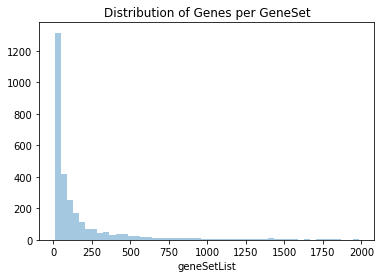

In [34]:
sns.distplot(g_gs['geneSetList'].apply(len), kde=False)
plt.title('Distribution of Genes per GeneSet');

In [35]:
g_gs = expand_df_on_col(g_gs, 'geneSetList')
g_gs.head(2)

,pathName,geneSetList,n_genes
0,GO_3_5_DNA_HELICASE_ACTIVITY,FBXO18,12
1,GO_3_5_DNA_HELICASE_ACTIVITY,RECQL5,12


In [36]:
g_gs['geneSetList'] = 'SYM:' + g_gs['geneSetList']
g_gs = g_gs.merge(sym_xref.rename(columns={'id': 'gene_id', 'xrefs': 'geneSetList'}), how='left', on='geneSetList')
g_gs.head(2)

,pathName,geneSetList,n_genes,gene_id
0,GO_3_5_DNA_HELICASE_ACTIVITY,SYM:FBXO18,12,NaN
1,GO_3_5_DNA_HELICASE_ACTIVITY,SYM:RECQL5,12,NCBIGene:9400


In [37]:
g_gs.count() / len(g_gs)

pathName       1.000000
geneSetList    1.000000
n_genes        1.000000
gene_id        0.950244
dtype: float64

In [38]:
gset_exp = gset_mapped.merge(g_gs.rename(columns={'pathName': 'geneSet'}), how='left', on='geneSet')
gset_exp.head(2)

,DB,ICD9code,PID,cases,category,controls,gaussName,geneSet,pval,selectedGenes,dis_source,gset_source,gset_id,geneSetList,n_genes,gene_id
0,DOID:11329,136.0,GO:0005549,205.0,infectious diseases,408429.0,Other infectious and parasitic diseases,GO_ODORANT_BINDING,0.004,"OR5H6,OR5K3,OR5K4,OR5L2,OR5J2,OR8U1,OR8A1,OR11...",DOID,GO,GO:0005549,SYM:OR5D16,92,NCBIGene:390144
1,DOID:11329,136.0,GO:0005549,205.0,infectious diseases,408429.0,Other infectious and parasitic diseases,GO_ODORANT_BINDING,0.004,"OR5H6,OR5K3,OR5K4,OR5L2,OR5J2,OR8U1,OR8A1,OR11...",DOID,GO,GO:0005549,SYM:OR9K2,92,NCBIGene:441639


In [39]:
gene_gset = gset_exp.dropna(subset=['gene_id', 'gset_id']).drop_duplicates(subset=['gene_id', 'gset_id'])
len(gene_gset)

375270

### Compare with network

In [40]:
gene_gset_tups = gene_gset[['gene_id', 'gset_id']].apply(tuple, axis=1)

In [41]:
mapped_gset = gene_gset['gset_id'].unique()

gset_lbl = nodes.query('id in @mapped_gset')['label'].unique().tolist()
nw_ggs_e_tup = combo.query('end_label in @gset_lbl and start_label in @g_lbl')[['start_id', 'end_id']].apply(tuple, axis=1)

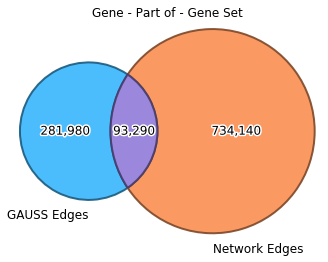

In [42]:
v = venn2_pretty([set(gene_gset_tups), set(nw_ggs_e_tup)], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set');

In [43]:
gene_kegg_tups = gene_gset.query('gset_source == "KEGG"')[['gene_id', 'gset_id']].apply(tuple, axis=1)

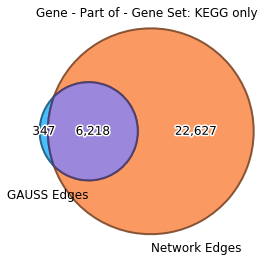

In [44]:
v = venn2_pretty([set(gene_kegg_tups), set([t for t in nw_ggs_e_tup if t[1].startswith('KEGG')])], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set: KEGG only');

In [45]:
gene_go_tups = gene_gset.query('gset_source == "GO"')[['gene_id', 'gset_id']].apply(tuple, axis=1)

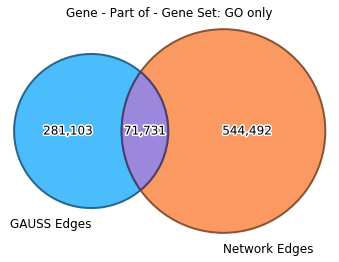

In [46]:
v = venn2_pretty([set(gene_go_tups), set([t for t in nw_ggs_e_tup if t[1].startswith('GO')])], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set: GO only');

In [47]:
gene_react_tups = gene_gset.query('gset_source == "REACT"')[['gene_id', 'gset_id']].apply(tuple, axis=1)

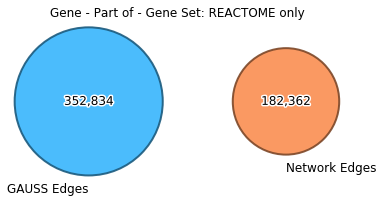

In [48]:
v = venn2_pretty([set(gene_go_tups), set([t for t in nw_ggs_e_tup if t[1].startswith('REACT')])], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set: REACTOME only');

Weird... did they do punning that we haven't done? (SOURCE OF THIS DATA IS MSIGDB)

# Map GeneSet to Disease to the Network

In [49]:
d_to_nw = dis_mapped[['dis_id', 'DB']].drop_duplicates().dropna()

In [50]:
gs_to_nw = gset_mapped[['gset_id', 'PID']].drop_duplicates().dropna()

In [51]:
gset_to_dis = df.merge(d_to_nw, on='DB', how='inner')
gset_to_dis = gset_to_dis.merge(gs_to_nw, on='PID', how='inner').drop_duplicates()

len(gset_to_dis)

34120

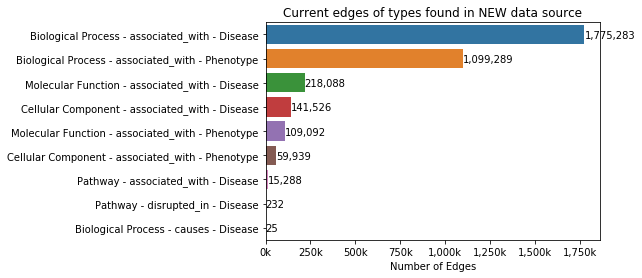

In [52]:
nw_es = combo.query('start_label in @gset_lbl and end_label in @dis_lbl')

res = (nw_es['start_label'] + ' - ' + nw_es['type'] + ' - ' + nw_es['end_label']).value_counts()

fmt_func = lambda x, y: '{:,}k'.format(int(x // 1000))

fig, ax = plt.subplots()
count_plot_h(res)
plt.title('Current edges of types found in NEW data source')
plt.xlabel('Number of Edges')
ax.xaxis.set_major_formatter(plt.FuncFormatter(fmt_func));

In [53]:
gset_to_dis_tup = gset_to_dis[['gset_id', 'dis_id']].drop_duplicates().apply(tuple, axis=1)

In [54]:
%%time
nw_gsd_e_tup = nw_es[['start_id', 'end_id']].apply(tuple, axis=1)

CPU times: user 1min 16s, sys: 177 ms, total: 1min 16s
Wall time: 1min 16s


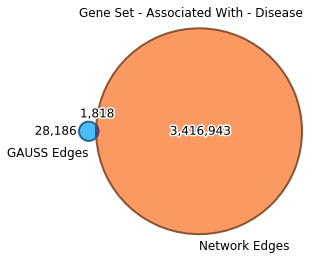

In [55]:
v = venn2_pretty([set(gset_to_dis_tup), set(nw_gsd_e_tup)], ['GAUSS Edges' ,'Network Edges'])
lbl = v.get_label_by_id('11')
x, y = lbl.get_position()
lbl.set_position((x, y+.3))

lbl = v.get_label_by_id('10')
x, y = lbl.get_position()
lbl.set_position((x-.55, y))
plt.title('Gene Set - Associated With - Disease');

In [56]:
overlap_e_tups = combo.query('start_id in @mapped_gset and end_id in @dis_ids')[['start_id', 'end_id']].apply(tuple, axis=1)

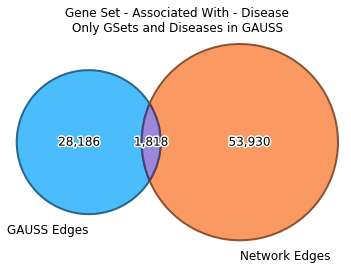

In [57]:
v = venn2_pretty([set(gset_to_dis_tup), set(overlap_e_tups)], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene Set - Associated With - Disease\nOnly GSets and Diseases in GAUSS');

In [58]:
nw_gauss_dis_deg = combo.query('type == "associated_with" and end_id in @dis_ids')['end_id'].value_counts()
nw_gauss_pw_deg = combo.query('type == "associated_with" and start_id in @mapped_gset')['start_id'].value_counts()

In [59]:
nw_all_dis_deg = combo.query('type == "associated_with" and end_label in @dis_lbl')['end_id'].value_counts()
nw_all_pw_deg = combo.query('type == "associated_with" and start_label in @gset_lbl')['start_id'].value_counts()

In [60]:
nw_other_dis_deg = combo.query('type == "associated_with" and end_label in @dis_lbl and end_id not in @dis_ids')['end_id'].value_counts()
nw_other_pw_deg = combo.query('type == "associated_with" and start_label in @gset_lbl and start_id not in @mapped_gset')['start_id'].value_counts()

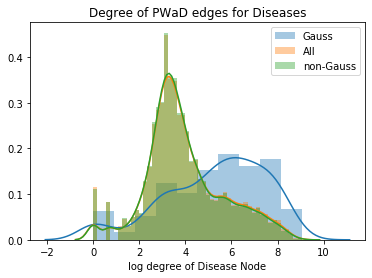

In [61]:
sns.distplot(np.log(nw_gauss_dis_deg), label = 'Gauss')
sns.distplot(np.log(nw_all_dis_deg), label = 'All')
sns.distplot(np.log(nw_other_dis_deg), label = 'non-Gauss')
plt.legend()
plt.xlabel('log degree of Disease Node')
plt.title('Degree of PWaD edges for Diseases');

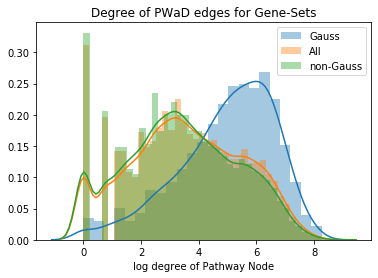

In [62]:
sns.distplot(np.log(nw_gauss_pw_deg), label = 'Gauss')
sns.distplot(np.log(nw_all_pw_deg), label = 'All')
sns.distplot(np.log(nw_other_pw_deg), label = 'non-Gauss')
plt.legend()
plt.xlabel('log degree of Pathway Node')
plt.title('Degree of PWaD edges for Gene-Sets');

In [63]:
dis_no_edge_in_nw = set(dis_ids) - set(nw_gauss_dis_deg.index)
pw_no_edge_in_nw = set(mapped_gset) - set(nw_gauss_pw_deg.index)

print('Diseases with Dis-Gset assoc: {:,}'.format(len(dis_ids) - len(dis_no_edge_in_nw)))
print('Diseases without Dis-Gset assoc: {:,}'.format(len(dis_no_edge_in_nw)))
print('% of new Diseases in GAUSS Dataset: {:1.2%}'.format(len(dis_no_edge_in_nw) / len(dis_ids)))
print('# Assoc. to diseases with no previous Assoc: {:,}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw'))))
print('% of total GAUSS assoc to Disease with no previous assoc: {:1.2%}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw')) / len(gset_to_dis)))

print('\n')
print('Gsets with previous Dis-Gset assoc: {:,}'.format(len(mapped_gset) - len(pw_no_edge_in_nw)))
print('Gsets without previous Dis-Gset assoc: {:,}'.format(len(pw_no_edge_in_nw)))
print('% of new Gsets in GAUSS Dataset: {:1.2%}'.format(len(pw_no_edge_in_nw) / len(mapped_gset)))
print('# Assoc to Gsets with no previous assoc: {:,}'.format(len(gset_to_dis.query('gset_id in @pw_no_edge_in_nw'))))
print('% of total GAUSS assoc to Gsets with no previous assoc: {:1.2%}'.format(len(gset_to_dis.query('gset_id in @pw_no_edge_in_nw')) / len(gset_to_dis)))


print('\n')
print('# Assoc between gsets and diseases both with no previous assoc: {:,}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw and gset_id in @pw_no_edge_in_nw'))))
print('{:1.2%}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw and gset_id in @pw_no_edge_in_nw')) / len(gset_to_dis)))

Diseases with Dis-Gset assoc: 313
Diseases without Dis-Gset assoc: 127
% of new Diseases in GAUSS Dataset: 28.86%
# Assoc. to diseases with no previous Assoc: 6,523
% of total GAUSS assoc to Disease with no previous assoc: 19.12%


Gsets with previous Dis-Gset assoc: 1,955
Gsets without previous Dis-Gset assoc: 423
% of new Gsets in GAUSS Dataset: 17.79%
# Assoc to Gsets with no previous assoc: 6,735
% of total GAUSS assoc to Gsets with no previous assoc: 19.74%


# Assoc between gsets and diseases both with no previous assoc: 1,398
4.10%


In [64]:
(nw_gauss_dis_deg <= 10).sum(), (nw_gauss_dis_deg > 10).sum() 

(29, 284)

In [65]:
(nw_gauss_pw_deg <= 10).sum(), (nw_gauss_pw_deg > 10).sum()

(157, 1798)

Just as a quick summary, Gauss had 431 Diseases and 2,378 Gene Sets that could be mapped to the network.


I checked the degree of 'Gene-set Associated-with Disease' edges for both the Diseases and the Gene-Sets found in the Gauss dataset, and comapred them to the degree of all the Diseases or Gene-sets in the network, to see if the new Gauss edges were selecteing for Diseases and Gene Sets we already have a lot of Edges for... I've plotted the distributions of log node degree for these different subsets separately. 

It appears that the Gauss dataset seems to be selecting for the Disease and Gene Sets that either already have a lot of GeneSet to Disease Associations, or have no assocations whatsoever. I think this results in a case wehre more data is better than no data, so I will be keeping these edges.

# Adding new information to the network

Because the Gene to Geneset comes from MSigDB and because it is VERY different from the Pathway and GO to gene annotations we already have, we will not be importing to the network.

Similarly, the Disease to Gene assocations, while novel, do not seem appropriate to add.  They are simply a combination where maximize the potential for finding statistical significance between the Gene Set and the Disease, but are not necessarily themselves significantly assocated with the disease individually.

Finally, for reasons enumerated above, we will be adding the GeneSet to Disease information as it add more vital information for the model to learn, predict, and explain from.

In [66]:
edges_out = gset_to_dis[['gset_id', 'dis_id', 'pval']].copy()
edges_out.columns = ['start_id', 'end_id', 'p_val']

edges_out['type'] = 'associated_with'
edges_out['dsrc_type'] = 'computed'
edges_out['comp_type'] = 'gauss_test'
edges_out['source'] = 'GAUSS'
edges_out['license'] = 'Unknown'

In [67]:
edges_out = pd.concat([edges, edges_out], sort=False, ignore_index=True)

In [68]:
edges_out = combine_group_cols_on_char(edges_out, ['start_id', 'type', 'end_id'])

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [69]:
edge_ids = edges_out[['start_id', 'end_id']].stack().unique()
nodes_out_filt = nodes.query('id in @edge_ids')

len(edge_ids) == len(nodes_out_filt)

True

## Save the result

In [70]:
this_name = '09_GAUSS_Geneset_to_Phenotype'
out_dir = Path('../2_pipeline/').joinpath(this_name).joinpath('out')
out_dir.mkdir(parents=True, exist_ok=True)

In [71]:
nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_out_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
edges_out.to_csv(out_dir.joinpath('edges.csv'), index=False)

In [79]:
edges_out.query('end_id in @pro and type == "inhibitor"')

UndefinedVariableError: local variable 'pro' is not defined

In [83]:
combo = combine_nodes_and_edges(nodes_out_filt, edges_out)

In [86]:
combo.query('start_label == "Disease" and end_label == "Disease" ')

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date,start_name,end_name,start_label,end_label
1307915,DOID:0060287,OMIM:121400,presents,computed,split,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,cornea plana,Cornea plana 1,Disease,Disease
1307916,DOID:0060287,OMIM:217300,presents,computed,split,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,cornea plana,Cornea plana 2,Disease,Disease
1311005,OMIM:121400,OMIM:121400,presents,computed,punning,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,Cornea plana 1,Cornea plana 1,Disease,Disease
1311006,OMIM:121400,OMIM:217300,presents,computed,punning,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,Cornea plana 1,Cornea plana 2,Disease,Disease
1311008,OMIM:217300,OMIM:121400,presents,computed,punning,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,Cornea plana 2,Cornea plana 1,Disease,Disease
1311009,OMIM:217300,OMIM:217300,presents,computed,punning,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,Cornea plana 2,Cornea plana 2,Disease,Disease
5881836,MESH:D000975,MESH:D020149,therapeutic,curated,NaN,NaN,NaN,CTD,http://ctdbase.org/about/legal.jsp,NaN,NaN,21107535,NaN,NaN,Oxidative stress,Manganese Poisoning,Disease,Disease
5885780,MESH:D003902,MESH:D059366,marker_or_mechanism,curated,NaN,NaN,NaN,CTD,http://ctdbase.org/about/legal.jsp,NaN,NaN,27504716,NaN,NaN,Facial cleansing,"Asthma, Occupational",Disease,Disease
6751551,MESH:D000779,DOID:13934,marker_or_mechanism,curated,NaN,NaN,NaN,CTD,http://ctdbase.org/about/legal.jsp,NaN,NaN,2524757,NaN,NaN,Local anesthetic,facial paralysis,Disease,Disease
6751555,MESH:D000779,DOID:0060052,marker_or_mechanism,curated,NaN,NaN,NaN,CTD,http://ctdbase.org/about/legal.jsp,NaN,NaN,8492141,NaN,NaN,Local anesthetic,neurological disorder,Disease,Disease


In [82]:
edges_out['type'].value_counts().tail(50)

adjacent_to                                       8
allosteric antagonist                             8
downregulator                                     8
chaperone                                         8
results_in_transport_across                       7
binding                                           7
negative allosteric modulator                     7
has_target_start_location                         6
has_target_end_location                           5
stimulator                                        5
adduct                                            5
releasing agent                                   5
produced_by                                       4
has_end_location                                  4
channel_for                                       4
has_start_location                                4
functionally_related_to                           4
releasing_agent                                   4
oxidizer                                          4
has_soma_loc

In [75]:
pro_id = nodes_out_filt.query('label == "Protein"')['id'].unique()